In [ ]:

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#Read the csv file
df = pd.read_csv('/content/gdrive/MyDrive/ColabNotebooks2/SentimentScoreCompound.csv')
df.head()

,Date,Compound,Price
0,1/1/2021,0.197971,0.005685
1,1/2/2021,0.075553,0.010615
2,1/3/2021,0.248539,0.009771
3,1/4/2021,0.082018,0.009767
4,1/5/2021,0.127530,0.009920


In [ ]:
df.tail()

,Date,Compound,Price
146,5/27/2021,0.210520,0.332945
147,5/28/2021,0.227102,0.311205
148,5/29/2021,0.244916,0.303110
149,5/30/2021,0.152507,0.302224
150,5/31/2021,0.145083,0.325810


In [ ]:
df = df[['Date','Price ']]
df.shape

(151, 2)

In [ ]:
df.set_index('Date',inplace=True)  
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
df

,Price
Date,
1/1/2021,0.005685
1/2/2021,0.010615
1/3/2021,0.009771
1/4/2021,0.009767
1/5/2021,0.009920
...,...
5/27/2021,0.332945
5/28/2021,0.311205
5/29/2021,0.303110


In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    '''
    Converts the original dataframe to a format which contains
    lag shifted values of inputs which can be used as input
    to the LSTM
    '''
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [ ]:
n_hours = 1  #no of time lags
n_features = 1 #no of features
n_obs = n_hours*n_features

In [ ]:
reframed = series_to_supervised(scaled, n_hours, 1)
reframed.head()

,var1(t-1),var1(t)
1,0.000000,0.007259
2,0.007259,0.006016
3,0.006016,0.006011
4,0.006011,0.006237
5,0.006237,0.007039


In [ ]:
reframed = reframed.drop(reframed.columns[-1], axis=1)
reframed.head()

,var1(t-1)
1,0.000000
2,0.007259
3,0.006016
4,0.006011
5,0.006237


In [ ]:
reframed.shape

(150, 1)

In [ ]:
values = reframed.values
n_train_hours = 135
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
train.shape,test.shape

((135, 1), (15, 1))

In [ ]:
# split into input and outputs
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]

In [ ]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(135, 1, 1) (135,) (15, 1, 1) (15,)


In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')



history = model.fit(train_X, train_y, epochs=40, batch_size=15, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 1, 50)             10400     
_________________________________________________________________
dropout_4 (Dropout)          (None, 1, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 1, 60)             26640     
_________________________________________________________________
dropout_5 (Dropout)          (None, 1, 60)             0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 1, 80)             45120     
_________________________________________________________________
dropout_6 (Dropout)          (None, 1, 80)             0         
_________________________________________________________________
lstm_7 (LSTM)                (None, 120)              

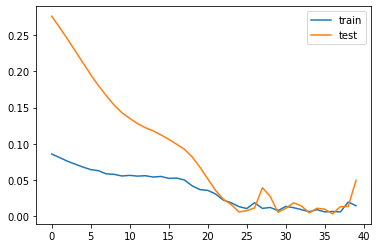

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

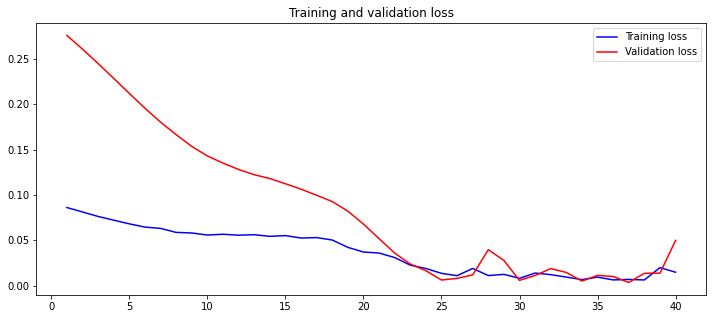

In [ ]:
#plt.style.use('ggplot')

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(loss) + 1)

    plt.figure(figsize=(12, 5))
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


plot_history(history)

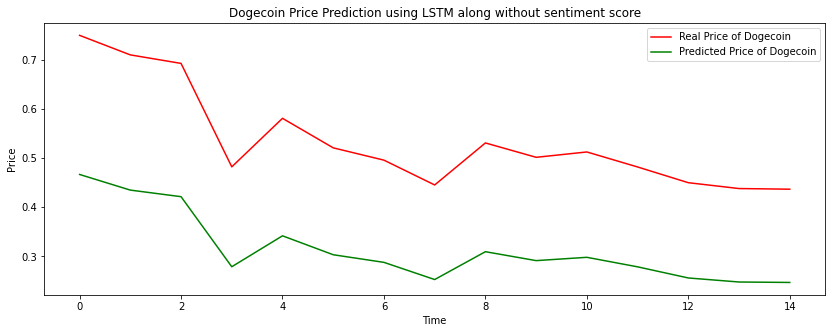

In [ ]:
# make a prediction
yhat = model.predict(test_X)
yhat
plt.figure(figsize=(14,5))
plt.plot(test_y, color = 'red', label = 'Real Price of Dogecoin')
plt.plot(yhat, color = 'green', label = 'Predicted Price of Dogecoin')
plt.title('Dogecoin Price Prediction using LSTM along without sentiment score')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error 
realVals = test_y
predictedVals = yhat
mse = mean_squared_error(realVals, predictedVals)
mse

0.0497517646022864

In [ ]:
test_X = test_X.reshape((test_X.shape[0], n_hours* n_features))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.151


In [ ]:
test_y

array([[0.74983984],
       [0.71007562],
       [0.69273388],
       [0.48217102],
       [0.58093559],
       [0.52083804],
       [0.49578888],
       [0.44527937],
       [0.53082242],
       [0.50157708],
       [0.5124609 ],
       [0.4819087 ],
       [0.44989471],
       [0.43797415],
       [0.43666929]])